In [1]:
import time
import cv2 as cv
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read the Data

In [2]:
# Load the Data
train = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")

# is_ma = True
istma_False = train[train["is_tma"]==False]
istma_False.tail()

,image_id,label,image_width,image_height,is_tma
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False
537,65533,HGSC,45190,33980,False


I will compare binary thresholding using CLAHE and without CLAHE

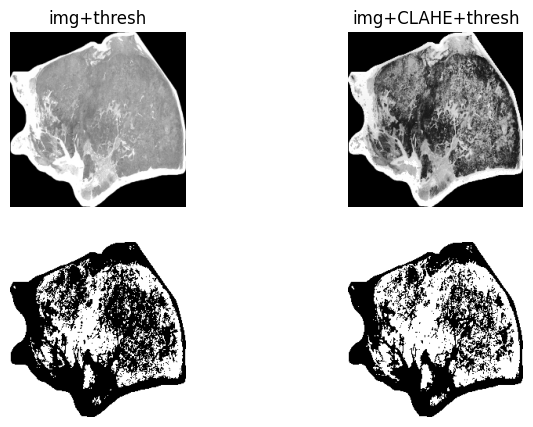

In [3]:
# Sample images for plotting
path = "../input/UBC-OCEAN/test_thumbnails/41_thumbnail.png"
image = cv.imread(path, 0)
image = cv.resize(image, (224, 224), interpolation=cv.INTER_AREA)

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(2, 2))
clahe_img = clahe.apply(image)
ret, thresh = cv.threshold(image, 150, 255, cv.THRESH_BINARY_INV)
ret, thresh1 = cv.threshold(clahe_img, 150, 255, cv.THRESH_BINARY_INV)

#  Plotting
fig, ax = plt.subplots(2,2, figsize=(8,5))
ax[0,0].imshow(image, cmap='gray'),ax[0,0].set_title('img+thresh'), ax[0,0].axis('off')
ax[0,1].imshow(clahe_img, cmap='gray'), ax[0,1].set_title('img+CLAHE+thresh'), ax[0,1].axis('off')
ax[1,0].imshow(thresh, cmap='gray'), ax[1,0].axis('off')
ax[1,1].imshow(thresh1, cmap='gray'), ax[1,1].axis('off')
plt.show()

## Preprocessing

### Slicing the Images

In [4]:
def get_slices(img_path, lower_limit, higher_limit=9999999, zoom_out=0, crop_square=0):
    #Reading image
    if '.png' in img_path: 
        img = cv.imread(img_path, 0)
    else:
        img = cv.imread(img_path, 0)
    
    width = img.shape[1]
    height = img.shape[0]
    
    # CLAHE + binary thresholding
    clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(2,2))
    clahe_img = clahe.apply(img)
    ret, thresh = cv.threshold(clahe_img, 150, 255, cv.THRESH_BINARY_INV)

    # detect the contours on the binary image using cv.CHAIN_APPROX_NONE
    contours, hierarchy = cv.findContours(image=thresh, mode=cv.RETR_EXTERNAL, 
                                           method=cv.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)

    #----------------------------------------------------------------------------#
    zoom_out_x1  = zoom_out
    zoom_out_x0  = zoom_out
    zoom_out_y0  = zoom_out
    zoom_out_y1  = zoom_out

    temps = []
    # Find bounding box 
    for c in contours:
        x,y,w,h = cv.boundingRect(c)
        area = cv.contourArea(c)
        
        if area>lower_limit and area<higher_limit:
            # Crop the image so that it is the same size
            if crop_square>0:
                c_height = (y+h)-(y)
                c_witdth = (x+w)-(x)
                
                center_y = int(c_height/2)
                center_x = int(c_witdth/2)
                
                center_y = (center_y + y)
                center_x = (center_x + x)
                zoom_out = int(crop_square/2)
                zoom_out_x1  = zoom_out
                zoom_out_x0  = zoom_out
                zoom_out_y0  = zoom_out
                zoom_out_y1  = zoom_out
                
                if center_y - zoom_out_y0 < 0: 
                    zoom_out_y1 = zoom_out_y1 - (center_y-zoom_out_y0)
                    zoom_out_y0 = center_y
                else:pass
                
                if center_y + zoom_out_y1 > height:
                    zoom_out_y1 = height - (center_y)
                    zoom_out_y0 = zoom_out_y0 + (zoom_out-zoom_out_y1)
                else:pass
                
                if center_x - zoom_out_x0<0:
                    zoom_out_x1 = zoom_out_x1 - (center_x-zoom_out_x0)
                    zoom_out_x0 = center_x
                else:pass
                
                if center_x+zoom_out > width:
                    zoom_out_x1 = width - (center_x)
                    zoom_out_x0 = zoom_out_x0 + (zoom_out-zoom_out_x1)
                else:pass
                
                
                temp = img[center_y-zoom_out_y0:center_y+zoom_out_y1, center_x-zoom_out_x0:center_x+zoom_out_x1]
                
            else:
                
                if y-zoom_out_y0 < 0: 
                    zoom_out_y1 = zoom_out_y1 - (y-zoom_out_y0)
                    zoom_out_y0 = y
                elif y+h+zoom_out_y1 > height:
                    zoom_out_y1 = height - (y+h)
                    zoom_out_y0 = zoom_out_y0 + (zoom_out-zoom_out_y1)

                elif x-zoom_out_x0<0:
                    zoom_out_x1 = zoom_out_x1 - (x-zoom_out_x0)
                    zoom_out_x0 = x
                elif x+w+zoom_out > width:
                    zoom_out_x1 = width - (x+w)
                    zoom_out_x0 = zoom_out_x0 + (zoom_out-zoom_out_x1)

                temp = img[y-zoom_out_y0:y+h+zoom_out_y1, x-zoom_out_x0:x+w+zoom_out_x1]
            
            
            if temp.size==0:
                temp = img[y:y+h, x:x+w]
                
        else: continue
            
        temps.append(temp)
            
    return temps

In [5]:
def data_img(dataframe, path):
    classes = []
    images = []
    for data in dataframe.iterrows():
        img_path = os.path.join(path,f"{str(data[1][0])}_thumbnail.png")
        contours = get_slices(img_path, 5000, zoom_out=100, crop_square=1000)

        for lol in contours:
            img_resize = cv.resize(lol, (224, 224), interpolation=cv.INTER_AREA)
            w,h = img_resize.shape
            rgb_img = np.zeros((w,h,3), dtype=np.uint8)
            rgb_img[:,:,0] = img_resize
            rgb_img[:,:,1] = img_resize
            rgb_img[:,:,2] = img_resize

            images.append(rgb_img)
            classes.append(data[1][1])
        
    return images, classes

In [6]:
path = "/kaggle/input/UBC-OCEAN/train_thumbnails"
images, classes = data_img(istma_False, path)

images = np.array(images)
print(images.shape)
print(len(classes))

(6383, 224, 224, 3)
6383


### Encoded

In [7]:
# Encode classes
le = LabelEncoder()
label = le.fit_transform(classes)
label_list = list(le.classes_)

print(len(label))
print(label_list)

6383
['CC', 'EC', 'HGSC', 'LGSC', 'MC']


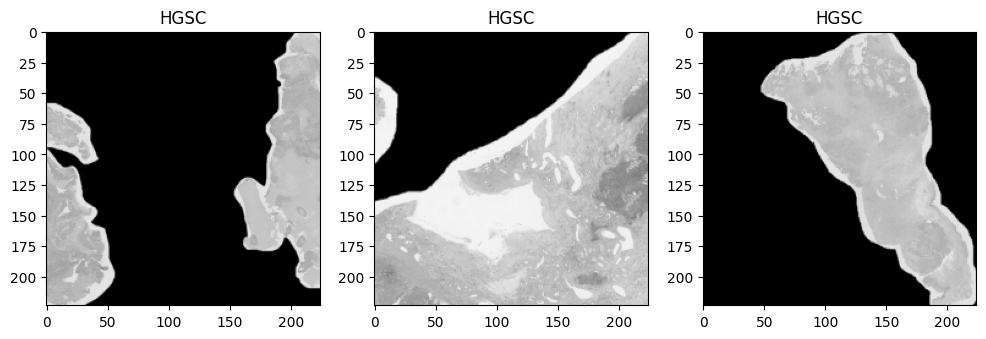

In [8]:
# Sample
random_n = np.random.randint(0,512,3)

fig, ax = plt.subplots(1,3, figsize=(12, 8))
j=0
for i in random_n:
    ax[j].imshow(images[i], cmap='gray'), ax[j].set_title(classes[i])
    j+=1

plt.show()

## Model

In [9]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics= ["accuracy"]
)

In [12]:
model_callback = EarlyStopping(
    monitor = 'val_loss', mode = 'min',
    patience = 3
)

history = model.fit(
    images, label,
    batch_size = 32,
    validation_split = 0.2,
    epochs = 100,
    callbacks = [model_callback]
)

Epoch 1/100


2023-11-09 01:13:32.670747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


160/160 [==============================] - 28s 89ms/step - loss: 1.8393 - accuracy: 0.4162 - val_loss: 1.4479 - val_accuracy: 0.4377
Epoch 2/100
160/160 [==============================] - 11s 67ms/step - loss: 1.0829 - accuracy: 0.5615 - val_loss: 1.5337 - val_accuracy: 0.4150
Epoch 3/100
160/160 [==============================] - 11s 67ms/step - loss: 0.8522 - accuracy: 0.6506 - val_loss: 1.5397 - val_accuracy: 0.4511
Epoch 4/100
160/160 [==============================] - 11s 67ms/step - loss: 0.6416 - accuracy: 0.7411 - val_loss: 1.8669 - val_accuracy: 0.4072


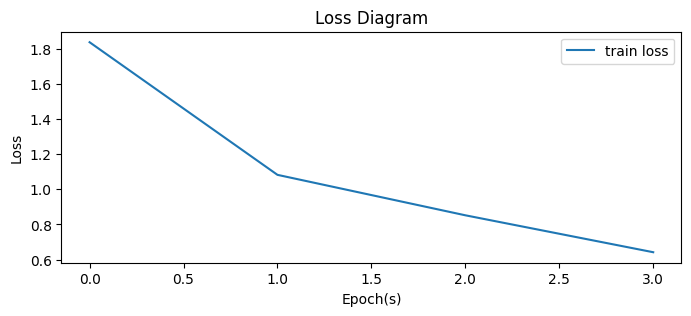

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['loss'])
#plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

## Testing

I will explain step by step how images are preprocessed starting from Read image -> Slicing the images (because the image has very high dimensions) -> Take several image slices using "contours & contoursArea opencv" -> Modeling using Efficientnet

(1790, 3000)

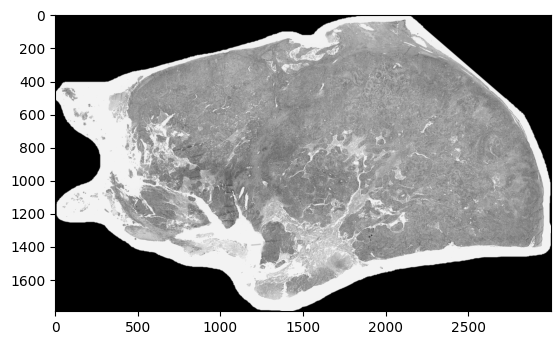

In [14]:
# Read the image
test_path = "/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png"
img = cv.imread(test_path, 0)
plt.imshow(img,cmap='gray')
img.shape

(8, 224, 224, 3)


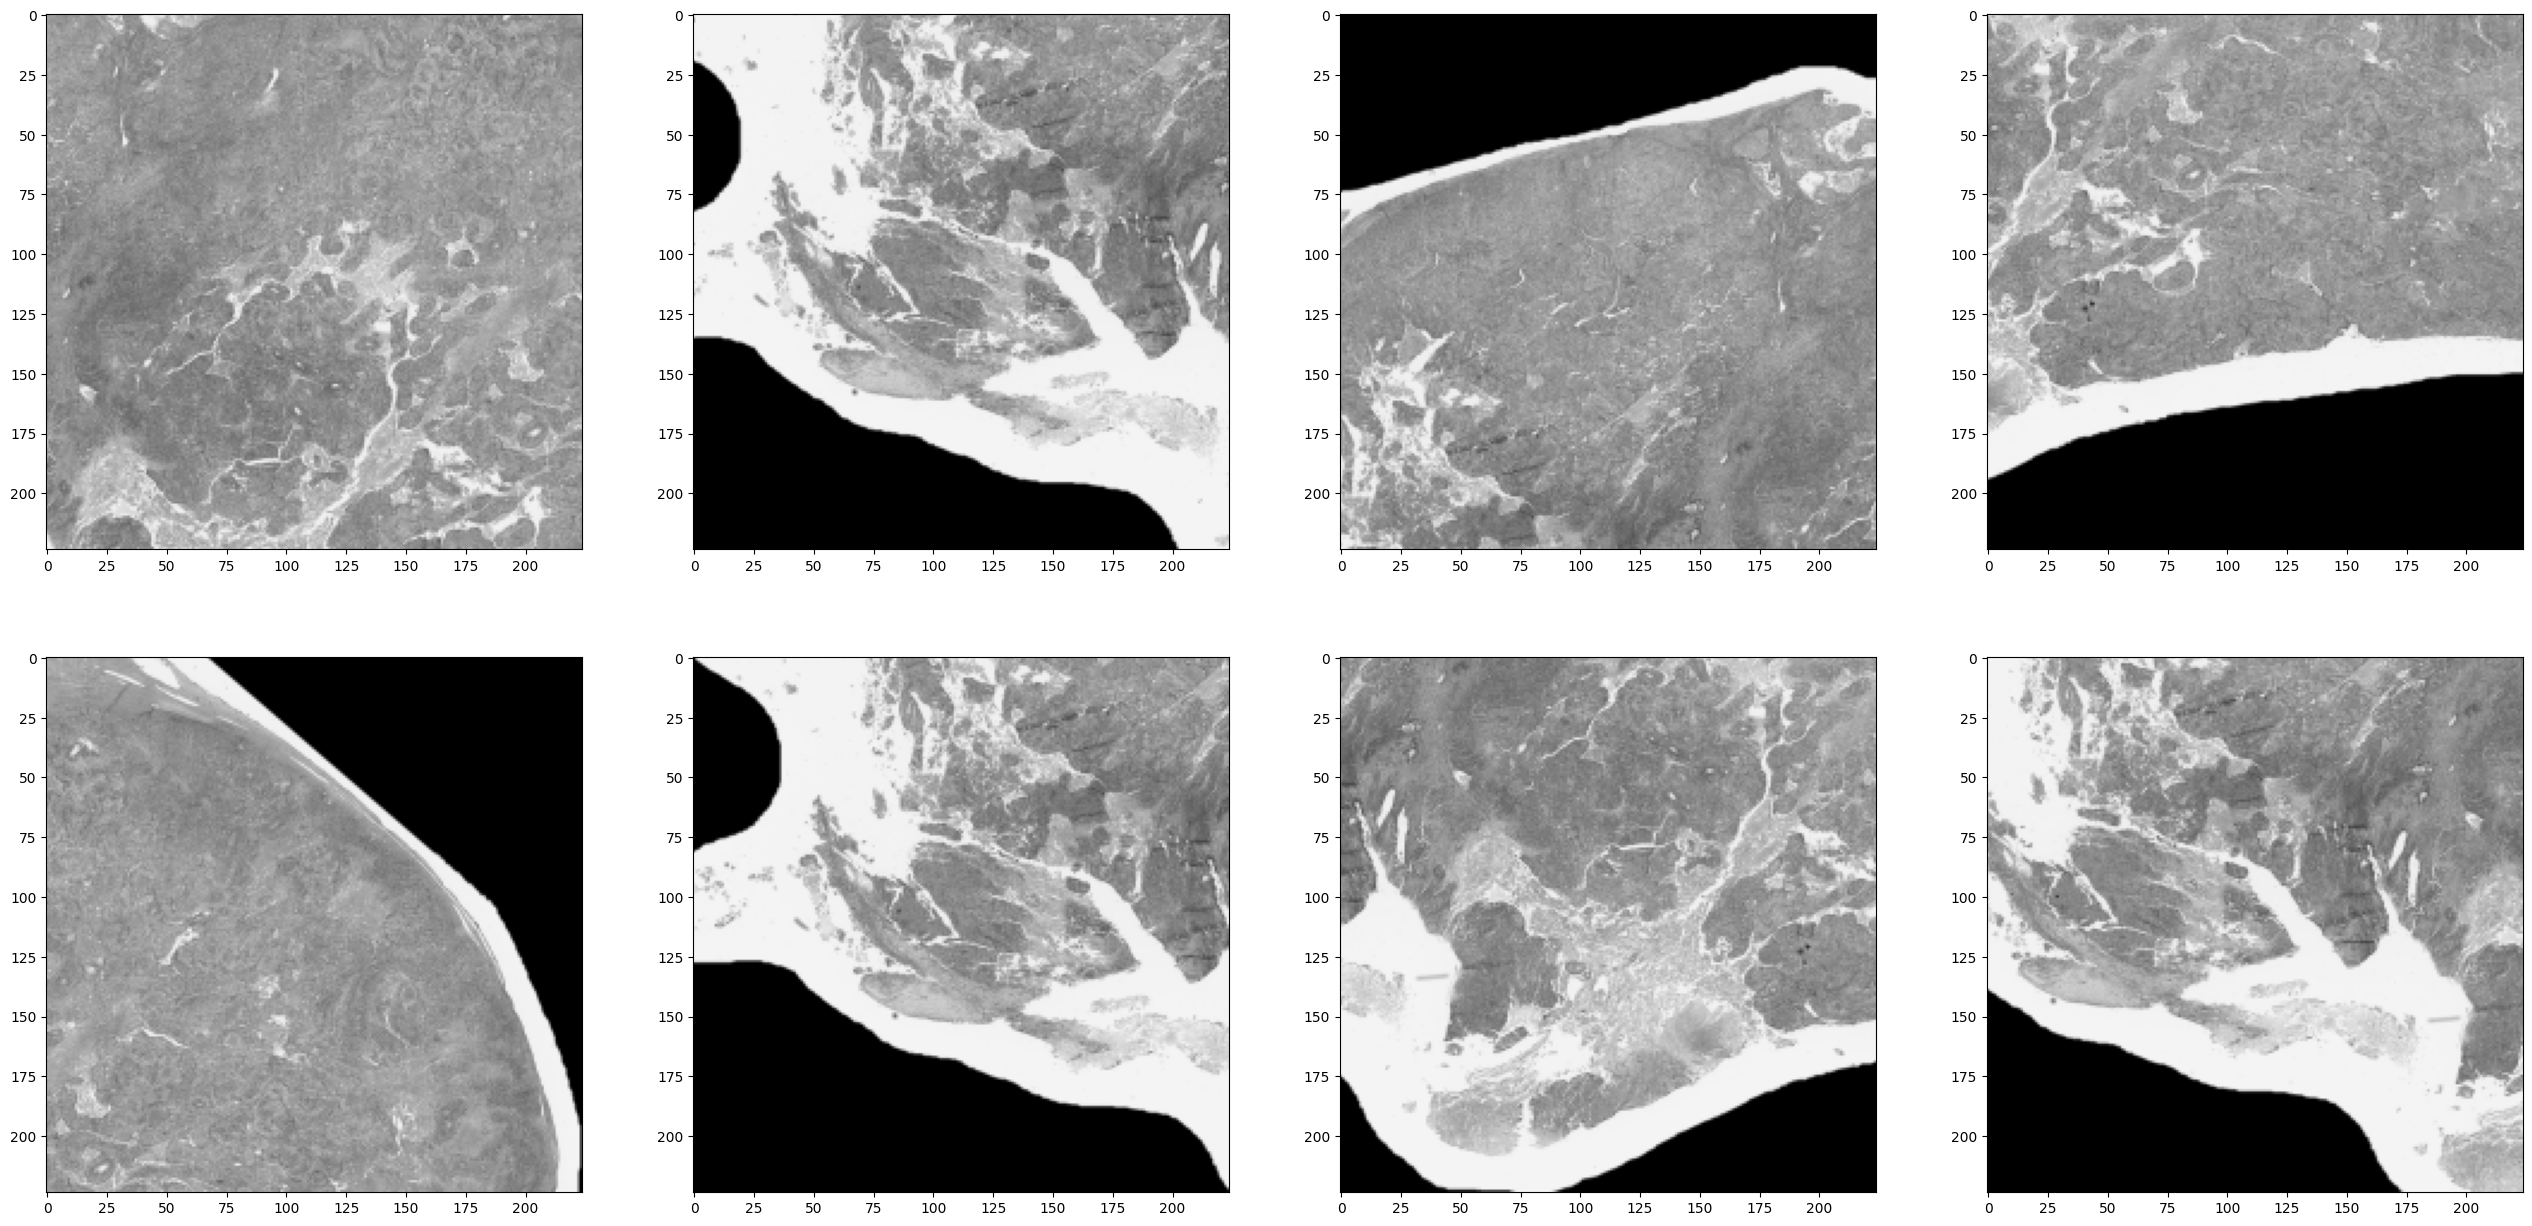

In [18]:
# Slicing the Images
img_test = []
contours = get_slices(test_path, 5000, zoom_out=100, crop_square=1000)
for lol in contours:
    img_resize = cv.resize(lol, (224, 224), interpolation=cv.INTER_AREA)
    w,h = img_resize.shape
    rgb_img = np.zeros((w,h,3), dtype=np.uint8)
    rgb_img[:,:,0] = img_resize
    rgb_img[:,:,1] = img_resize
    rgb_img[:,:,2] = img_resize
    
    img_test.append(rgb_img)
    
img_test = np.array(img_test)
print(img_test.shape)

plt.figure(figsize=(32,32))
for i, n in enumerate(img_test):
    try:
        plt.subplot(4,4,i+1)
        plt.grid(False)
        plt.imshow(n)
    except:pass

1/1 [==============================] - 0s 31ms/step


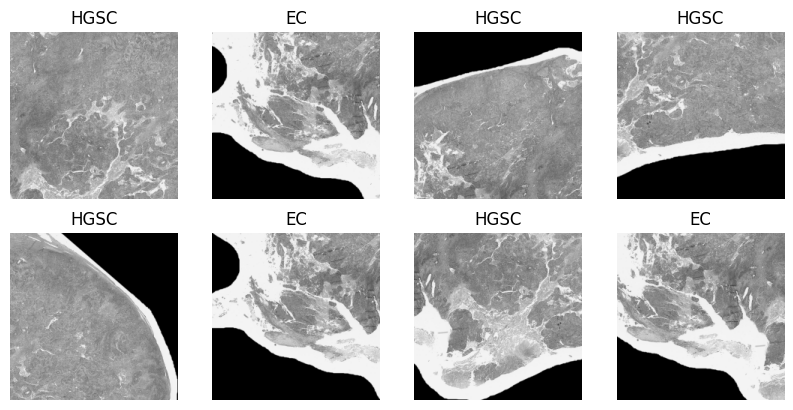

In [25]:
# Model Predict
classes = model.predict(img_test)

# Plotting the Result
plt.figure(figsize=(10,10))
for i, n in enumerate(img_test):
    try:
        plt.subplot(4,4,i+1)
        #plt.grid(False)
        plt.imshow(n, cmap='gray')
        plt.title(label_list[np.argmax(classes[i])])
        plt.axis('off')
    except:pass

From one image --> 8 images (results from sliced images), then predicted. From 8 classes of prediction results:
- 5/8 -> HGSC
- 3/8 -> EC

# If you like, upvote pls  :)

## Acknowledgement:


Iurick Santos https://www.kaggle.com/code/iuryck/quick-blood-clot-slicing/notebook